In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import pickle
import torch

In [2]:
import sys
import os

# Add the 'project' directory to the path
sys.path.append(os.path.abspath('..'))

from project_code.data.load_data import load_dataframes
from project_code.data.prepare_data_sklearn import get_features_targets
from project_code.data.prepare_data_pytorch import prepare_data_tensors
from project_code.utils.results import get_best_model_file
from project_code.inference.parameters import get_core_parameter_predictions, convert_output_to_parameter_predictions, PARAMETER_COLS
from project_code.evaluate.prediction_error import evaluate_parameter_predictions_on_data, compute_metrics, METRIC_LABEL_TO_NAME
from project_code.evaluate.metrics import log_accuracy_ratio, symmetric_mean_absolute_percentage_error, mean_deb_loss
from project_code.plotters.infeasibility import method_labels, par_to_latex

# Loading data and models

In [3]:
datasets_folder = f'../data/processed/'

dataset_of_model = {
    'SRTaxo1NN': 'biologist_no_pub_age',  
    'Taxo1NN': 'biologist_no_pub_age',  
    'RandomForestRegressor': 'final_taxonomy_ecocodes',
    'MultiTaskElasticNet': 'final_taxonomy_ecocodes',
    'MLP': 'final_taxonomy_ecocodes',
    'MLPSC': 'final_taxonomy_ecocodes',
    'DEBNetHC': 'final_taxonomy_ecocodes',
    'DEBNetSC': 'final_taxonomy_ecocodes',
}

save_figures_folder = '../paper/figures'

## Loading best models

In [4]:
def load_model(model_file, results_folder):
    if model_file[-4:] == '.pkl':
        with open(f"{results_folder}/models/{model_file}", 'rb') as f:
            model = pickle.load(f)
    elif model_file[-4:] == '.pth':
        model = torch.load(f"{results_folder}/models/{model_file}", weights_only=False)
        model.eval()
    return model

In [5]:
best_models = {}
best_models_test_performance_files = {}
for mt in dataset_of_model.keys():  
    results_folder = f'../results/{dataset_of_model[mt]}'
    metric = 'logQ'
    model_file = get_best_model_file(results_folder=results_folder, model_type=mt, metric=metric)
    #print(mt, model_file)
    if model_file is not None:
        best_models[mt] = load_model(model_file, results_folder)
        test_performance_filename =  model_file[:-4] + '.csv'
        best_models_test_performance_files[mt] = os.path.join(results_folder, 'test_performance', test_performance_filename)

print(best_models.keys())

dict_keys(['SRTaxo1NN', 'Taxo1NN', 'MLP', 'MLPSC'])


## Loading data

In [6]:
all_dfs = {}
all_col_types = {}
all_data = {}
device = torch.device("cpu")
for dataset_name in list(set(dataset_of_model.values())):
    results_folder = f'../results/{dataset_name}'
    dfs, col_types = load_dataframes(dataset_name=dataset_name, data_split='train_test', datasets_folder=datasets_folder)
    all_dfs[dataset_name] = dfs
    all_col_types[dataset_name] = col_types 
    if 'biologist' in dataset_name:
        if 'SRTaxo1NN' in best_models:
            model = best_models['SRTaxo1NN']
        elif 'Taxo1NN' in best_models:
            model = best_models['Taxo1NN']
        else:
            continue
        encoded_dfs = {}
        # Encoded data with trained model encoders
        for split in ('train', 'test'):
            encoded_dfs[split] = model.regressor.encode_data(all_dfs[dataset_name][split])
        all_data[dataset_name] = get_features_targets(data=encoded_dfs, col_types=all_col_types[dataset_name])
    else:
        data_tensors, dataloaders, datasets, scalers = prepare_data_tensors(data=dfs, col_types=col_types,
                                                                            batch_size=1,
                                                                            scaling_type='log_standardize',
                                                                            device=device)
        all_data[dataset_name] = data_tensors
                                                                            

# Visualize predictions

In [7]:
taxonomy_cols = [col for col in all_col_types['final_taxonomy_ecocodes']['input']['all'] if 'class' in col]

hue_series = {
    'metamorphosis': pd.concat([all_dfs['biologist_no_pub_age'][data_split]['metamorphosis'] for data_split in ['train', 'test']]),
    'class': pd.concat([pd.from_dummies(all_dfs['final_taxonomy_ecocodes'][data_split][taxonomy_cols], sep='_') for data_split in ['train', 'test']])['class'],
    'climate': None,
    'habitat': None,
    'migrate': None,
    'food': None
}

hue_orders = {
    'metamorphosis': [False, True],
    'class': None,
    'climate': None,
    'habitat': None,
    'migrate': None,
    'food': None
}


In [8]:
def plot_residuals_df(model_type, plot_kind, data_split, groupby, scale):
    # Get data for the model
    dataset_name = dataset_of_model[model_type]
    data = all_data[dataset_name]
    col_types = all_col_types[dataset_name]
    model = best_models[model_type]

    # Get predictions:
    X = data[data_split]['input']
    y_true_ps = data[data_split]['output']
    if 'DEBNet' in model_type:
        y_pred_ps = model.predict(torch.tensor(X, dtype=torch.float32))
    elif 'Taxo1NN' in model_type and data_split in ['train', 'val']:
        distance_matrix = model.regressor_._compute_distance_matrix(model.regressor_.train_data, model.regressor_.train_data, data_split='train')
        y_hat, indices = model.regressor_.get_predictions_from_distance_matrix(distance_matrix)
        y_pred_ps = model.regressor_.apply_scaling_relationships(model.regressor_.train_data, y_hat, indices)
    else:
        y_pred_ps = model.predict(data[data_split]['input'])

    if scale == 'model':
        cols_to_plot = col_types['output']['all']
        target_df = pd.DataFrame(y_true_ps, columns=col_types['output']['all'])
        pred_df = pd.DataFrame(y_pred_ps, columns=col_types['output']['all'])
        
    elif scale == 'parameter':
        cols_to_plot = PARAMETER_COLS     
        mask = data[data_split]['mask']       
        target_df = convert_output_to_parameter_predictions(y=y_true_ps, y_true=y_true_ps, mask=mask, col_types=col_types)
        pred_df = convert_output_to_parameter_predictions(y=y_pred_ps, y_true=y_true_ps, mask=mask, col_types=col_types)

    target_df.set_index(all_dfs[dataset_name][data_split].index, inplace=True)
    pred_df.set_index(all_dfs[dataset_name][data_split].index, inplace=True)
    if plot_kind == 'residual_vs_predicted':
        if scale == 'model':
            residuals_df = target_df - pred_df
        elif scale == 'parameter':
            residuals_df = (target_df - pred_df) / target_df  

    # Plot predictions vs targets  
    n_cols = 3
    n_rows = np.ceil(len(cols_to_plot) / n_cols).astype(int)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 5*n_rows), tight_layout=True)
    fig.suptitle(model_type, fontsize=16)
    margin_factor = 0.05
    for i, col in enumerate(cols_to_plot):
        ax = axes[i // n_cols, i % n_cols]

        if scale == 'parameter' and col != 'kap':
            plot_log_scale_x = True
            if plot_kind == 'residual_vs_predicted':
                plot_log_scale_y = False
            else:
                plot_log_scale_y = True
        elif scale == 'model' and (col in col_types['output']['log'] or 'Taxo1NN' in model_type):
            plot_log_scale_x = True
            plot_log_scale_y = True
        else:
            plot_log_scale_x = False
            plot_log_scale_y = False
        
        if plot_kind == 'residual_vs_predicted':
            sns.scatterplot(x=pred_df[col], y=residuals_df[col], ax=ax, hue=hue_series[groupby], hue_order=hue_orders[groupby]) # Fix
            min_v = (1-margin_factor)*min(target_df[col].min(), pred_df[col].min())
            max_v = (1+margin_factor)*max(target_df[col].max(), pred_df[col].max())
            ax.set_xlim([min_v, max_v])

            ax.plot([min_v, max_v], [0, 0], 'k--')
            ax.set_ylabel('Residuals (actual - predicted)')

        elif plot_kind == 'actual_vs_predicted':
            sns.scatterplot(x=pred_df[col], y=target_df[col], ax=ax, hue=hue_series[groupby], hue_order=hue_orders[groupby])
            min_v = (1-margin_factor)*min(target_df[col].min(), pred_df[col].min())
            max_v = (1+margin_factor)*max(target_df[col].max(), pred_df[col].max())
            ax.set_xlim([min_v, max_v])
            ax.set_ylim([min_v, max_v])
            ax.plot([min_v, max_v], [min_v, max_v], 'k--')
            ax.set_ylabel('Actual values')

        if plot_log_scale_x:
            ax.set_xscale('log')
        else:
            ax.set_xscale('linear')
        
        if plot_log_scale_y:
            ax.set_yscale('log')
        else:
            ax.set_yscale('linear')

        ax.set_xlabel('Predicted values') 
        #r2 = metrics.r2_score(target_df, pred_df)
        ax.set_title(f"{col}")

model_selector = widgets.Dropdown(options=list(best_models.keys()), value='MLP', description='Model:')
plot_selector = widgets.Dropdown(options=['actual_vs_predicted', 'residual_vs_predicted'], value='actual_vs_predicted', description='Plot Type:')
data_split_selector = widgets.Dropdown(options=['train', 'test'], value='test', description='Data Split: ')
groupby_selector = widgets.Dropdown(options=['metamorphosis', 'class', 'climate', 'habitat', 'migrate', 'food'])
scale_selector = widgets.Dropdown(options=['model', 'parameter',], value='parameter')
widgets.interactive(plot_residuals_df, model_type=model_selector, plot_kind=plot_selector, data_split=data_split_selector, groupby=groupby_selector, scale=scale_selector)

interactive(children=(Dropdown(description='Model:', index=2, options=('SRTaxo1NN', 'Taxo1NN', 'MLP', 'MLPSC')…

## HC-NN Predicitons for test sets

C:\Users\diogo\AppData\Local\Temp\ipykernel_37932\3171596098.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_ps = model.predict(torch.tensor(X, dtype=torch.float32))


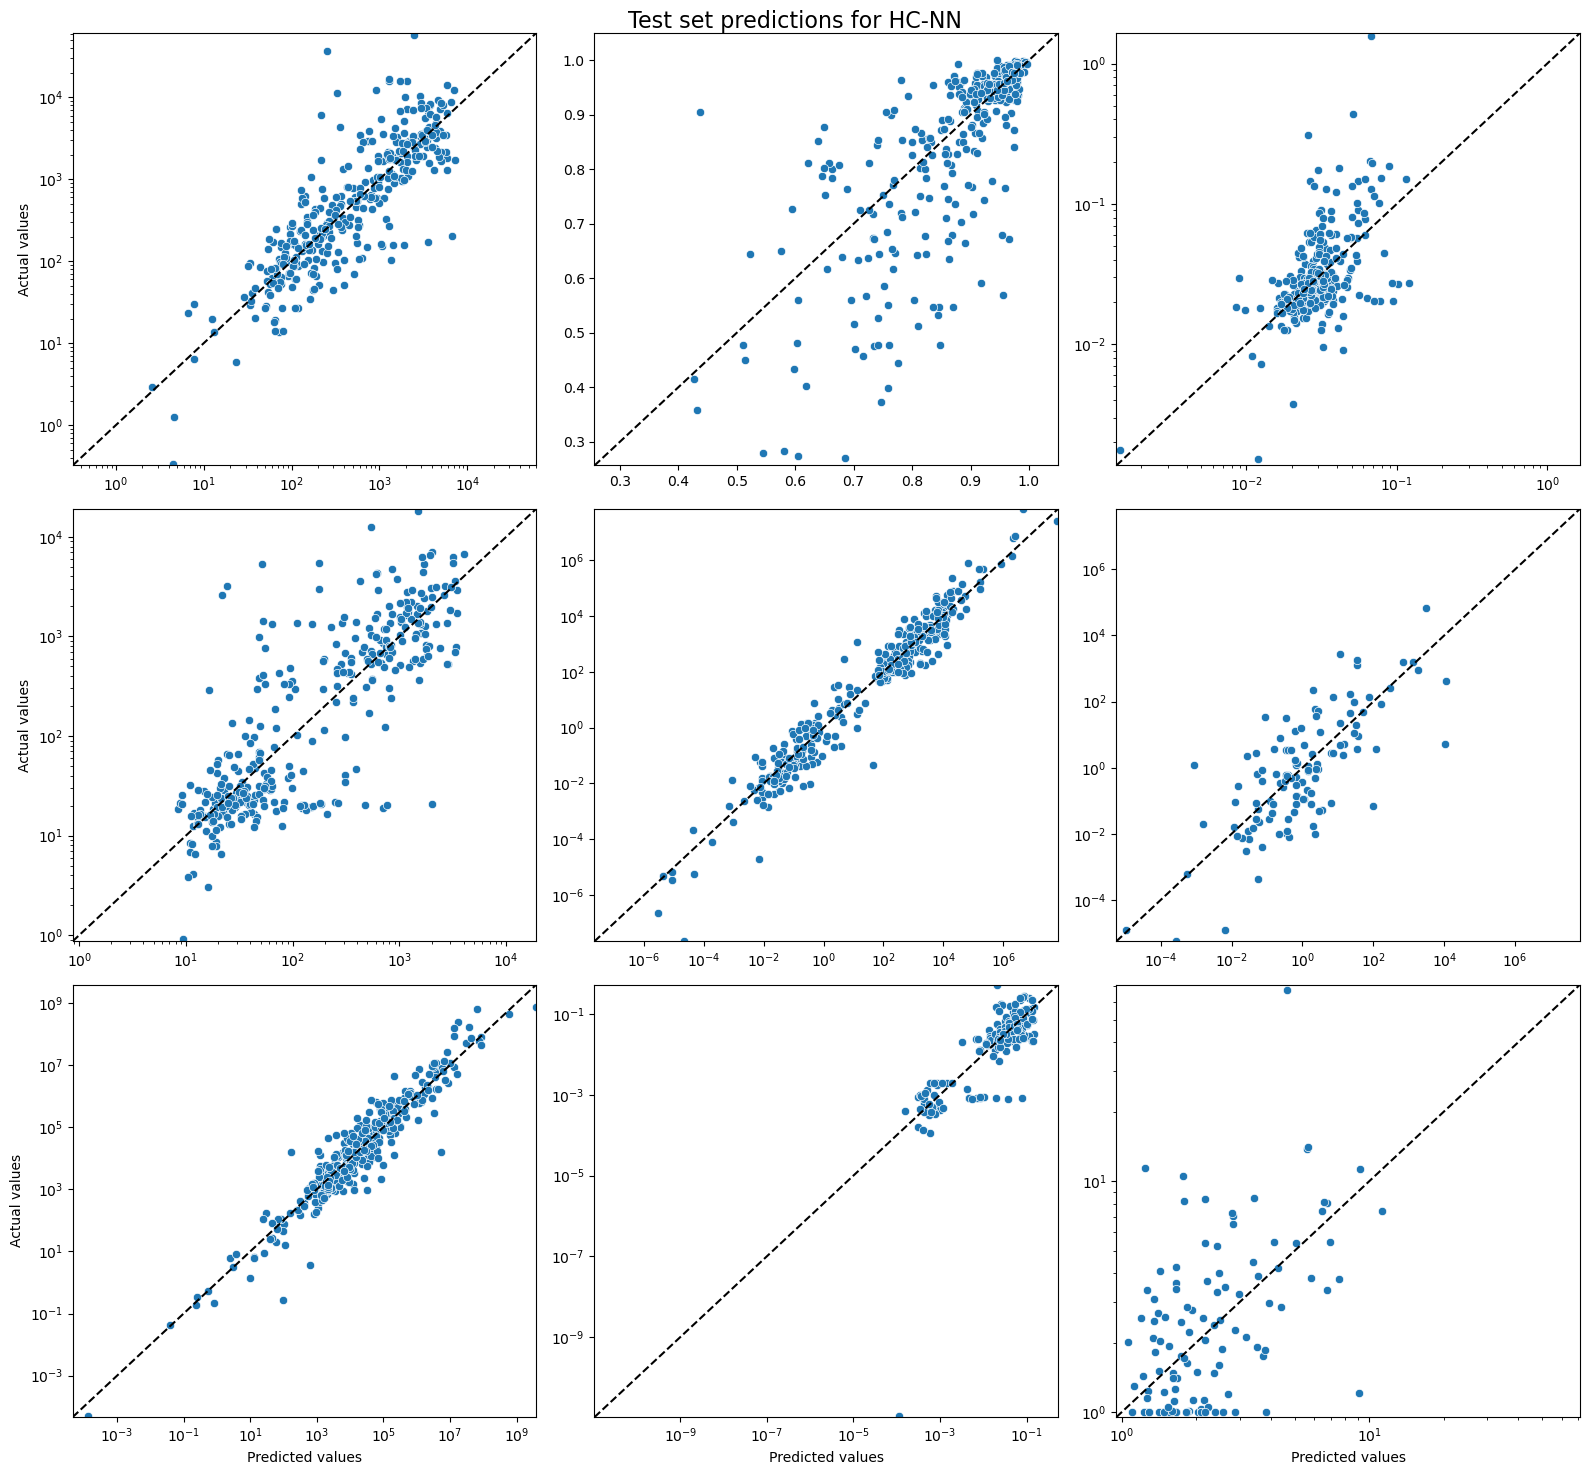

In [ ]:
model_type = 'MLP'
# Get data for the model
dataset_name = dataset_of_model[model_type]
data = all_data[dataset_name]
col_types = all_col_types[dataset_name]
model = best_models[model_type]


        
cols_to_plot = PARAMETER_COLS
data_split = 'test'
mask = data[data_split]['mask']    
# Get predictions:
X = data[data_split]['input']
y_true_ps = data[data_split]['output']
y_pred_ps = model.predict(torch.tensor(X, dtype=torch.float32))   
target_df = convert_output_to_parameter_predictions(y=y_true_ps, y_true=y_true_ps, mask=mask, col_types=col_types)
pred_df = convert_output_to_parameter_predictions(y=y_pred_ps, y_true=y_true_ps, mask=mask, col_types=col_types)

target_df.set_index(all_dfs[dataset_name][data_split].index, inplace=True)
pred_df.set_index(all_dfs[dataset_name][data_split].index, inplace=True)
target_df['data_split'] = data_split
pred_df['data_split'] = data_split 

# Plot predictions vs targets  
n_cols = 3
n_rows = np.ceil(len(cols_to_plot) / n_cols).astype(int)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 5*n_rows), tight_layout=True)
fig.suptitle(f"Test set predictions for {method_labels[model_type]}", fontsize=16)
margin_factor = 0.05
for i, col in enumerate(cols_to_plot):
    ax = axes[i // n_cols, i % n_cols]

    if col not in ('kap'):
        plot_log_scale_x = True
        plot_log_scale_y = True
    else:
        plot_log_scale_x = False
        plot_log_scale_y = False
    
    param_mask = data[data_split]['param_mask'].astype(bool)
    x = pred_df[col].values[param_mask[:, i]]
    y = target_df[col].values[param_mask[:, i]]

    sns.scatterplot(x=x, y=y, ax=ax) 
    min_v = (1-margin_factor)*min(target_df[col].min(), pred_df[col].min())
    max_v = (1+margin_factor)*max(target_df[col].max(), pred_df[col].max())
    ax.set_xlim([min_v, max_v])
    ax.set_ylim([min_v, max_v])
    ax.plot([min_v, max_v], [min_v, max_v], 'k--')

    if plot_log_scale_x:
        ax.set_xscale('log')
    else:
        ax.set_xscale('linear')
    
    if plot_log_scale_y:
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')

    if i % n_cols == 0:
        ax.set_ylabel('Actual values')

    if i // n_cols == n_rows - 1:
        ax.set_xlabel('Predicted values')

    
    #r2 = metrics.r2_score(target_df, pred_df)
    #ax.set_title(f"${par_to_latex[col]}$")
    
figure_filename = 'HC_NN_test_predictions'
fig.savefig(f'{save_figures_folder}/{figure_filename}.pdf', dpi=300, transparent=True)
fig.savefig(f'{save_figures_folder}/{figure_filename}.png', dpi=300, transparent=True)


## HC-NN Predictions for all sets

C:\Users\diogo\AppData\Local\Temp\ipykernel_37932\3835676853.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_ps = model.predict(torch.tensor(X, dtype=torch.float32))
C:\Users\diogo\AppData\Local\Temp\ipykernel_37932\3835676853.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_ps = model.predict(torch.tensor(X, dtype=torch.float32))
C:\Users\diogo\AppData\Local\Temp\ipykernel_37932\3835676853.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_ps = model.predict(torch.tensor(X, dtype=torch.float32))


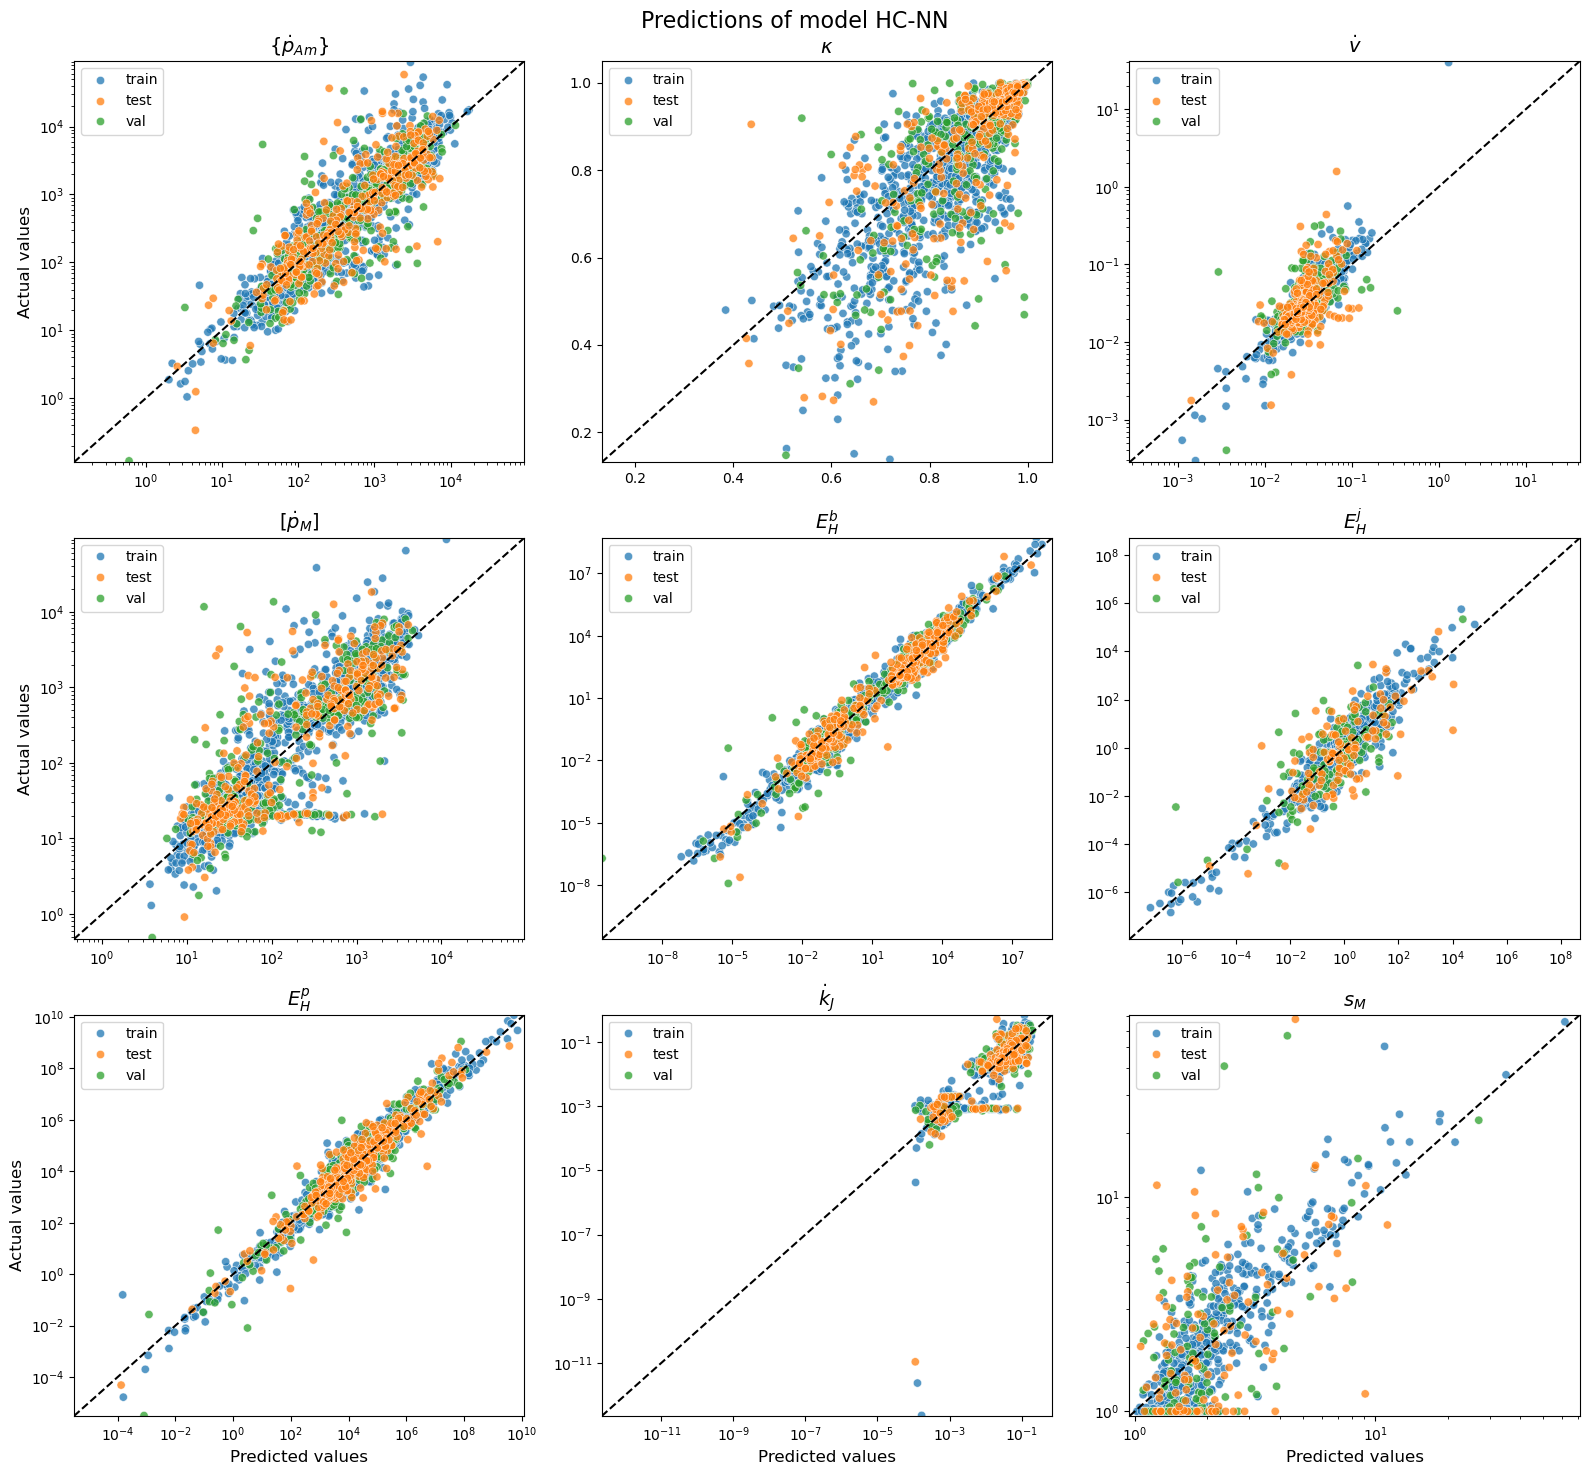

In [10]:
model_type = 'MLP'
model = best_models[model_type]
# Get data for the model
dataset_name = dataset_of_model[model_type]
dfs, col_types = load_dataframes(dataset_name=dataset_name, data_split='train_val_test', datasets_folder=datasets_folder)
col_types = all_col_types[dataset_name]
data, dataloaders, datasets, scalers = prepare_data_tensors(data=dfs, col_types=col_types,
                                                                            batch_size=1,
                                                                            scaling_type='log_standardize',
                                                                            device=device)

        
cols_to_plot = PARAMETER_COLS
target_df = pd.DataFrame()
pred_df = pd.DataFrame()
param_mask = np.empty((0, len(cols_to_plot)), dtype=bool)

for data_split in ('train', 'val', 'test'):
    mask = data[data_split]['mask']    
    # Get predictions:
    X = data[data_split]['input']
    y_true_ps = data[data_split]['output']
    y_pred_ps = model.predict(torch.tensor(X, dtype=torch.float32))   
    split_target_df = convert_output_to_parameter_predictions(y=y_true_ps, y_true=y_true_ps, mask=mask, col_types=col_types)
    split_pred_df = convert_output_to_parameter_predictions(y=y_pred_ps, y_true=y_true_ps, mask=mask, col_types=col_types)

    split_target_df.set_index(dfs[data_split].index, inplace=True)
    split_pred_df.set_index(dfs[data_split].index, inplace=True)
    split_target_df['data_split'] = data_split
    split_pred_df['data_split'] = data_split 

    target_df = pd.concat([target_df, split_target_df])
    pred_df = pd.concat([pred_df, split_pred_df])
    param_mask = np.concatenate([param_mask, data[data_split]['param_mask'].astype(bool)])

# Plot predictions vs targets  
n_cols = 3
n_rows = np.ceil(len(cols_to_plot) / n_cols).astype(int)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 5*n_rows), tight_layout=True)
fig.suptitle(f"Predictions of model {method_labels[model_type]}", fontsize=16)
margin_factor = 0.05
for i, col in enumerate(cols_to_plot):
    ax = axes[i // n_cols, i % n_cols]

    if col not in ('kap'):
        plot_log_scale_x = True
        plot_log_scale_y = True
    else:
        plot_log_scale_x = False
        plot_log_scale_y = False
    
    x = pred_df[col].values[param_mask[:, i]]
    y = target_df[col].values[param_mask[:, i]]
    hue = target_df['data_split'].values[param_mask[:, i]]

    sns.scatterplot(x=x, y=y, hue=hue, hue_order=('train', 'test', 'val'), ax=ax,
                    alpha=0.75) 
    min_v = (1-margin_factor)*min(target_df[col].min(), pred_df[col].min())
    max_v = (1+margin_factor)*max(target_df[col].max(), pred_df[col].max())
    ax.set_xlim([min_v, max_v])
    ax.set_ylim([min_v, max_v])
    ax.plot([min_v, max_v], [min_v, max_v], 'k--')

    if plot_log_scale_x:
        ax.set_xscale('log')
    else:
        ax.set_xscale('linear')
    
    if plot_log_scale_y:
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')

    if i % n_cols == 0:
        ax.set_ylabel('Actual values', fontsize=12)

    if i // n_cols == n_rows - 1:
        ax.set_xlabel('Predicted values', fontsize=12)

    
    #r2 = metrics.r2_score(target_df, pred_df)
    ax.set_title(f"${par_to_latex[col]}$", fontsize=14)
    #ax.set_title(f"{col}", fontsize=14)

    
figure_filename = 'HC_NN_all_predictions'
fig.savefig(f'{save_figures_folder}/{figure_filename}.pdf', dpi=300, transparent=True)
fig.savefig(f'{save_figures_folder}/{figure_filename}.png', dpi=300, transparent=True)


# Save parameter predictions

### AmP values

In [11]:
dataset_name = 'biologist_no_pub_age'
dfs = all_dfs[dataset_name]
col_types = all_col_types[dataset_name]
#gt_df = pd.concat({ds: dfs[ds][col_types['output']['all']] for ds in ('train', 'test')}).reset_index(level=0, names='data_split')
#gt_pars_df = get_core_parameter_predictions(dfs, pred_df=gt_df)
#gt_pars_df.to_csv(f'../results/parameter_predictions/AmP_predictions.csv', float_format='%.6e')
#gt_pars_df

### ML models

In [12]:
def save_parameter_predictions(model_type):
    model = best_models[model_type]
    dataset_name = dataset_of_model[model_type]
    dfs = all_dfs[dataset_name]
    data = all_data[dataset_name]
    col_types = all_col_types[dataset_name]
    pred_df = pd.DataFrame()
    for split in ('train', 'test'):
        if 'Taxo1NN' in model_type and split == 'train':
            train_distance_matrix = model.regressor_._compute_distance_matrix(model.regressor_.train_data, model.regressor_.train_data, data_split='train')
            y_hat, indices = model.regressor_.get_predictions_from_distance_matrix(train_distance_matrix)
            y_pred = model.regressor_.apply_scaling_relationships(model.regressor_.train_data, y_hat, indices)
        else:
            y_pred = model.predict(data[split]['input'])
        split_pred_df = convert_output_to_parameter_predictions(y=y_pred, y_true=data[split]['output'], mask=data[split]['mask'], col_types=col_types)
        split_pred_df.set_index(dfs[split].index, inplace=True)
        split_pred_df['data_split'] = split
        pred_df = pd.concat([pred_df, split_pred_df])
    pars_df = get_core_parameter_predictions(dfs, pred_df=pred_df)
    predictions_file_name = f'../results/parameter_predictions/{model_type}_predictions.csv'
    pars_df.to_csv(predictions_file_name, float_format='%.10e')
    print(f'Saved parameter predictions for model {model_type} in {predictions_file_name}')

    return pars_df

In [13]:
#for model_type in best_models:
#    save_parameter_predictions(model_type)

# Compare parameter predictions

In [14]:
df = pd.read_csv(f'../results/parameter_predictions/MLPSC_predictions.csv', index_col=0)
df[df['E_Hj'] <= df['E_Hb']]

,data_split,z,p_M,kap,v,E_G,E_Hb,E_Hx,E_Hj,E_Hp,k_J
species,,,,,,,,,,,
Trichomycterus_itacarambiensis,test,1.642551,49.700497,0.98,0.044,5230.125523,0.769503,0.807978,0.729091,145.414948,0.002


### Get test performance of bijection method

In [15]:
bijection_pars_df = pd.read_csv('../results/parameter_predictions/BijectionMethod_predictions.csv', index_col=0)
bijection_test_pred_df = pd.DataFrame(index=bijection_pars_df[bijection_pars_df['data_split'] == 'test'].index, columns=PARAMETER_COLS)
#bijection_test_pred_df['s_M'] = bijection_test_pred_df['s_M'].astype(float)
bijection_test_pred_df['s_M'] = bijection_test_pred_df['s_M'].astype(float).fillna(1)
for col in PARAMETER_COLS:
    if col in bijection_pars_df.columns:
        bijection_test_pred_df[col] = bijection_pars_df[col]
bijection_test_pred_df['p_Am'] = bijection_pars_df['z'] * bijection_pars_df['p_M'] / bijection_pars_df['kap']
# Avoid zero values so that metrics do not throw errors. These species do not have the parameter 'E_Hj', so they will not be counted 
bijection_test_pred_df.loc[bijection_test_pred_df['E_Hj'] == 0, 'E_Hj'] = 1e-10
# Remove species with negative parameter values
bijection_test_pred_df = bijection_test_pred_df[(bijection_test_pred_df > 0).all(axis=1)]
bijection_test_pred_df

,p_Am,kap,v,p_M,E_Hb,E_Hj,E_Hp,k_J,s_M
Row,,,,,,,,,
Ablennes_hians,204.192056,0.995529,0.023155,18.000000,0.004203,4.244735e-03,1.462911e+03,0.002,1.003315
Acanthogobius_flavimanus,303.431495,0.223522,0.025282,18.000000,11.657664,1.000000e-10,1.544606e+05,0.002,1.000000
Acanthopagrus_arabicus,165.619046,0.781396,0.011852,18.000000,0.080097,8.089748e-02,8.847198e+04,0.002,1.003314
Achoerodus_gouldii,645.999369,0.966786,0.009990,56.805908,0.003282,3.315085e-03,4.307519e+05,0.002,1.003300
Achondrostoma_arcasii,87.631588,0.949880,0.029838,18.000000,0.152398,1.539219e-01,1.388489e+02,0.002,1.003301
...,...,...,...,...,...,...,...,...,...
Triakis_scyllium,479.016675,0.673624,0.056890,18.000000,59454.402917,1.000000e-10,7.861941e+06,0.002,1.000000
Trichiurus_lepturus,256.693836,0.966538,0.061333,18.000000,0.049401,4.989452e-02,5.396383e+03,0.002,1.003317
Trygonoptera_mucosa,191.281017,0.905845,0.028382,18.000000,19332.078225,1.000000e-10,2.227602e+05,0.002,1.000000


In [16]:
dataset_name = 'biologist_no_pub_age'
col_types = all_col_types[dataset_name]
dfs = all_dfs[dataset_name]
data = all_data[dataset_name]
bijection_test_target_df = pd.concat([
    convert_output_to_parameter_predictions(
        y=data[ds]['output'], 
        y_true=data[ds]['output'], 
        mask=data[ds]['mask'], 
        col_types=col_types
        ).set_index(dfs[ds].index) 
        for ds in ('train', 'test')
        ])
#bijection_test_target_df.set_index(, inplace=True)
bijection_test_target_df = bijection_test_target_df.loc[bijection_test_pred_df.index.intersection(bijection_test_target_df.index)]
bijection_test_target_df

,p_Am,kap,v,p_M,E_Hb,E_Hj,E_Hp,k_J,s_M
Ablennes_hians,231.831215,0.996902,0.022324,21.267776,0.002605,0.022575,9.554723e+02,0.002000,2.052446
Acanthogobius_flavimanus,2908.056570,0.852166,0.021518,1339.581785,0.095383,0.095383,1.019992e+04,0.002000,1.000000
Acanthopagrus_arabicus,112.802903,0.826942,0.019444,15.278785,0.109483,0.305283,1.001329e+05,0.002000,1.406871
Achoerodus_gouldii,291.060831,0.967792,0.021022,16.485124,0.011852,0.011852,9.801152e+05,0.000951,1.000000
Achondrostoma_arcasii,106.322535,0.976805,0.024900,20.536843,0.058368,0.084490,1.642727e+02,0.002000,1.130436
...,...,...,...,...,...,...,...,...,...
Triakis_scyllium,619.286631,0.725200,0.048242,27.655143,37800.522343,37800.522347,6.219762e+06,0.002000,1.000000
Trichiurus_lepturus,275.519487,0.935603,0.053236,19.340549,0.086460,0.086460,1.077879e+04,0.002000,1.000000
Trygonoptera_mucosa,209.751004,0.883966,0.031200,19.409976,31353.782098,31353.782102,3.233304e+05,0.002000,1.000000
Urobatis_halleri,203.298232,0.939204,0.101747,15.739111,12279.661531,12279.661532,1.545930e+05,0.002000,1.000000


In [17]:
# Get param mask
param_mask = np.zeros((len(bijection_test_pred_df), len(PARAMETER_COLS)))
for i, species in enumerate(bijection_test_pred_df.index.values):
    for ds in ('train', 'test'):
        if species in dfs[ds].index:
            idx = dfs[ds].index.get_loc(species)
            param_mask[i, :] = data[ds]['param_mask'][idx, :]
param_mask

array([[1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 0., ..., 1., 0., 1.],
       ...,
       [1., 1., 0., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.]], shape=(146, 9))

In [18]:
bijection_test_metrics_df = compute_metrics(
        y_true=bijection_test_target_df.values,
        y_pred=bijection_test_pred_df.values,
        mask=param_mask,
        output_col_names=PARAMETER_COLS,
        metrics=[
            log_accuracy_ratio,
            symmetric_mean_absolute_percentage_error,
            mean_deb_loss,
            'mean_absolute_percentage_error',
        ],
        return_std=True,
    )
formatted_score = format(bijection_test_metrics_df.loc['log_accuracy_ratio'].loc['mean'].mean(), '.4e').replace('.', '')
bijection_test_results_path = f'../results/bijection_method/logQ_{formatted_score}_BijectionMethod.csv'
bijection_test_metrics_df.to_csv(bijection_test_results_path)
best_models_test_performance_files['BijectionMethod'] = bijection_test_results_path
bijection_test_metrics_df   

p_Am  \
metric                                   agg                         
log_accuracy_ratio                       mean    1.270136554344056   
                                         std    2.8605059047458665   
symmetric_mean_absolute_percentage_error mean    35.59517698969364   
                                         std     34.88845021823276   
mean_deb_loss                            mean   0.2835290900584614   
                                         std   0.31858080337917566   
mean_absolute_percentage_error           mean      11080366.241406   

                                                               kap  \
metric                                   agg                         
log_accuracy_ratio                       mean   0.1561730908820156   
                                         std    0.2902582590953379   
symmetric_mean_absolute_percentage_error mean    7.390810920852027   
                                         std      7.24766280807211   
mean_deb_loss                            mean  0.03669790993408908   
                                         std   0.10504864532000814   
mean_absolute_percentage_error           mean              0.13255   

                                                                 v  \
metric                                   agg                         
log_accuracy_ratio                       mean   0.8175793674993963   
                                         std     1.506862405464418   
symmetric_mean_absolute_percentage_error mean   28.180835286835453   
                                         std    27.622036877994525   
mean_deb_loss                            mean  0.20590916433837939   
                                         std   0.26094927268827073   
mean_absolute_percentage_error           mean             0.741551   

                                                               p_M  \
metric                                   agg                         
log_accuracy_ratio                       mean   1.4811109556161242   
                                         std     4.294510900752538   
symmetric_mean_absolute_percentage_error mean   32.837779302888734   
                                         std     32.18684449399736   
mean_deb_loss                            mean   0.2561925876828939   
                                         std    0.3228997678029709   
mean_absolute_percentage_error           mean  183033762599.602966   

                                                              E_Hb  \
metric                                   agg                         
log_accuracy_ratio                       mean    1.142470397264838   
                                         std     1.246137636425405   
symmetric_mean_absolute_percentage_error mean    40.37186366775512   
                                         std     39.56915828182504   
mean_deb_loss                            mean   0.3304235770624114   
                                         std   0.32954591013658513   
mean_absolute_percentage_error           mean            11.435584   

                                                             E_Hj  \
metric                                   agg                        
log_accuracy_ratio                       mean  2.7730471119234017   
                                         std   2.5171221486308473   
symmetric_mean_absolute_percentage_error mean   66.56874894272843   
                                         std    65.24036377249206   
mean_deb_loss                            mean  0.6153145756303212   
                                         std   0.3593801167873208   
mean_absolute_percentage_error           mean            2.759653   

                                                              E_Hp  \
metric                                   agg                         
log_accuracy_ratio                       mean   0.9112199991564697   
                                         std    0.9222163842430898   
symme

## Test performance

## Add standard deviation to error computations

In [19]:
# Evaluate parameter predictions in parameter scale
"""
for model_name, model in best_models.items():
    dataset_name = dataset_of_model[model_name]
    data = all_data[dataset_name]
    col_types = all_col_types[dataset_name]
    print(f"\nEvaluating parameter predictions for model {model_name} on dataset {dataset_name}")
    evaluate_parameter_predictions_on_data(
                data=data['test'],
                col_types=col_types,
                model=model,
                print_score=True,
                save_score=True,
                results_save_path=best_models_test_performance_files[model_name],
                return_std=True,
            )
"""

'\nfor model_name, model in best_models.items():\n    dataset_name = dataset_of_model[model_name]\n    data = all_data[dataset_name]\n    col_types = all_col_types[dataset_name]\n    print(f"\nEvaluating parameter predictions for model {model_name} on dataset {dataset_name}")\n    evaluate_parameter_predictions_on_data(\n                data=data[\'test\'],\n                col_types=col_types,\n                model=model,\n                print_score=True,\n                save_score=True,\n                results_save_path=best_models_test_performance_files[model_name],\n                return_std=True,\n            )\n'

In [20]:
model_list = ['BijectionMethod', 'MLP', 'MLPSC', 'Taxo1NN', 'SRTaxo1NN']
index = pd.MultiIndex.from_product([METRIC_LABEL_TO_NAME.keys(), ['mean', 'std'], model_list,], names=['metric', 'agg', 'model',])
test_perf_df = pd.DataFrame(index=index, columns=PARAMETER_COLS)
for model_type in model_list:
    model_test_df = pd.read_csv(f"{best_models_test_performance_files[model_type]}", index_col=(0,1))
    for (metric_name, agg) in model_test_df.index:
        test_perf_df.loc[(metric_name, agg, model_type), :] = model_test_df.loc[(metric_name, agg)]

In [21]:
test_perf_df.loc['log_accuracy_ratio'].loc['mean']

,p_Am,kap,v,p_M,E_Hb,E_Hj,E_Hp,k_J,s_M
model,,,,,,,,,
BijectionMethod,1.270137,0.156173,0.817579,1.481111,1.14247,2.773047,0.91122,1.80793,0.801223
MLP,0.672437,0.096931,0.37317,0.828903,0.974915,2.054981,0.877042,0.84983,0.53738
MLPSC,0.670657,0.101099,0.377094,0.843735,0.9491,2.021209,0.893235,0.858123,0.538482
Taxo1NN,1.111187,0.154789,0.489079,1.205439,0.86641,2.836773,1.443652,1.121036,0.673296
SRTaxo1NN,1.079972,0.157888,0.504526,1.250902,1.667017,2.738423,1.387126,1.13844,0.598367


In [22]:
test_perf_df.loc['symmetric_mean_absolute_percentage_error'].loc['mean']

,p_Am,kap,v,p_M,E_Hb,E_Hj,E_Hp,k_J,s_M
model,,,,,,,,,
BijectionMethod,35.595177,7.390811,28.180835,32.837779,40.371864,66.568749,36.142007,46.5818,32.288643
MLP,28.702351,4.783999,17.251511,33.742659,39.039056,60.279699,36.119939,32.473532,24.814101
MLPSC,28.809148,4.986351,17.394264,34.509384,38.033801,60.325399,36.612578,32.924385,25.005459
Taxo1NN,40.729805,7.567505,21.545279,40.550471,23.835797,68.081517,46.86878,39.873817,29.430854
SRTaxo1NN,39.048528,7.715784,22.146448,40.825762,49.771674,66.754104,47.971582,40.453595,27.150111


## Mean metrics tables

In [23]:
n_digits_of_metric = {
    'log_accuracy_ratio': 3,
    'symmetric_mean_absolute_percentage_error': 2,
}

for metric, n_digits in n_digits_of_metric.items():
    print(f'\n\n{METRIC_LABEL_TO_NAME[metric]} test performance:\n')
    for mt in model_list:
        row = test_perf_df.loc[metric].loc['mean'].loc[mt]
        line = f"{method_labels[mt]} "
        for par in PARAMETER_COLS:
            er = row[par]
            if er == min(test_perf_df.loc[metric].loc['mean', par]):
                line += f' & \\textbf{{{er:.{n_digits}f}}}'
            else:
                line += f' & {er:.{n_digits}f}'
        line += ' \\\\'
        print(line)



logQ test performance:

Bijection  & 1.270 & 0.156 & 0.818 & 1.481 & 1.142 & 2.773 & 0.911 & 1.808 & 0.801 \\
HC-NN  & 0.672 & \textbf{0.097} & \textbf{0.373} & \textbf{0.829} & 0.975 & 2.055 & \textbf{0.877} & \textbf{0.850} & \textbf{0.537} \\
SC-NN  & \textbf{0.671} & 0.101 & 0.377 & 0.844 & 0.949 & \textbf{2.021} & 0.893 & 0.858 & 0.538 \\
Taxo1NN  & 1.111 & 0.155 & 0.489 & 1.205 & \textbf{0.866} & 2.837 & 1.444 & 1.121 & 0.673 \\
SR-Taxo1NN  & 1.080 & 0.158 & 0.505 & 1.251 & 1.667 & 2.738 & 1.387 & 1.138 & 0.598 \\


sMAPE test performance:

Bijection  & 35.60 & 7.39 & 28.18 & \textbf{32.84} & 40.37 & 66.57 & 36.14 & 46.58 & 32.29 \\
HC-NN  & \textbf{28.70} & \textbf{4.78} & \textbf{17.25} & 33.74 & 39.04 & \textbf{60.28} & \textbf{36.12} & \textbf{32.47} & \textbf{24.81} \\
SC-NN  & 28.81 & 4.99 & 17.39 & 34.51 & 38.03 & 60.33 & 36.61 & 32.92 & 25.01 \\
Taxo1NN  & 40.73 & 7.57 & 21.55 & 40.55 & \textbf{23.84} & 68.08 & 46.87 & 39.87 & 29.43 \\
SR-Taxo1NN  & 39.05 & 7.72 & 22.15

## Mean +- std metrics tables

In [24]:
test_perf_df.loc['log_accuracy_ratio'].loc['mean', 'p_Am'].min()

0.670656732478527

In [25]:
par_to_latex = {
    'p_Am': r'\pAm',
    'kap': r'\kappa',
    'v': r'\dot{v}',
    'p_M': r'\pM',
    'E_Hb': r'\matlevel{b}',
    'E_Hj': r'\matlevel{j}',
    'E_Hp': r'\matlevel{p}',
    'k_J': r'\kJ',
    's_M': r's_M',
}


In [26]:
for metric, n_digits in n_digits_of_metric.items():
    print(f'\n\n{METRIC_LABEL_TO_NAME[metric]} test performance:\n')

    # Print header
    print(r'\toprule')
    line = r'\textbf{Parameter}'
    for mt in model_list:
        line += f' & \\textbf{{{method_labels[mt]}}}'
    line += ' \\\\'
    print(line)
    print(r'\midrule')

    # Print mean +- std per parameter
    for p in PARAMETER_COLS:
        line = f"${par_to_latex[p]}$ "
        min_mean_value = test_perf_df.loc[metric].loc['mean', p].min()
        for mt in model_list:
            mean = test_perf_df.loc[metric].loc['mean'].loc[mt, p]
            std = test_perf_df.loc[metric].loc['std'].loc[mt, p]
            er = f"{mean:.{n_digits}f} $\\pm$ {std:.{n_digits}f}"
            if mean == min_mean_value:
                line += f' & \\textbf{{{er}}}'
            else:
                line += f' & {er}'
        line += ' \\\\'
        print(line)
    print(r'\bottomrule')




logQ test performance:

\toprule
\textbf{Parameter} & \textbf{Bijection} & \textbf{HC-NN} & \textbf{SC-NN} & \textbf{Taxo1NN} & \textbf{SR-Taxo1NN} \\
\midrule
$\pAm$  & 1.270 $\pm$ 2.861 & 0.672 $\pm$ 0.697 & \textbf{0.671 $\pm$ 0.675} & 1.111 $\pm$ 1.126 & 1.080 $\pm$ 1.158 \\
$\kappa$  & 0.156 $\pm$ 0.290 & \textbf{0.097 $\pm$ 0.147} & 0.101 $\pm$ 0.152 & 0.155 $\pm$ 0.209 & 0.158 $\pm$ 0.213 \\
$\dot{v}$  & 0.818 $\pm$ 1.507 & \textbf{0.373 $\pm$ 0.431} & 0.377 $\pm$ 0.439 & 0.489 $\pm$ 0.585 & 0.505 $\pm$ 0.598 \\
$\pM$  & 1.481 $\pm$ 4.295 & \textbf{0.829 $\pm$ 0.839} & 0.844 $\pm$ 0.827 & 1.205 $\pm$ 1.367 & 1.251 $\pm$ 1.448 \\
$\matlevel{b}$  & 1.142 $\pm$ 1.246 & 0.975 $\pm$ 0.918 & 0.949 $\pm$ 0.926 & \textbf{0.866 $\pm$ 1.700} & 1.667 $\pm$ 1.819 \\
$\matlevel{j}$  & 2.773 $\pm$ 2.517 & 2.055 $\pm$ 1.729 & \textbf{2.021 $\pm$ 1.694} & 2.837 $\pm$ 2.435 & 2.738 $\pm$ 2.371 \\
$\matlevel{p}$  & 0.911 $\pm$ 0.922 & \textbf{0.877 $\pm$ 0.825} & 0.893 $\pm$ 0.836 & 1.444 $\pm$

In [27]:
for metric, n_digits in n_digits_of_metric.items():
    print(f'\n\n{METRIC_LABEL_TO_NAME[metric]} test performance:\n')

    # Print header
    print(r'\toprule')
    line = r'\textbf{Parameter}'
    for mt in model_list:
        line += f' & \\multicolumn{{2}}{{c}}{{\\textbf{{{method_labels[mt]}}}}}'
    line += ' \\\\'
    print(line)
    print(r'\midrule')

    # Print mean +- std per parameter
    for p in PARAMETER_COLS:
        line = f"${par_to_latex[p]}$ "
        min_mean_value = test_perf_df.loc[metric].loc['mean', p].min()
        for mt in model_list:
            mean = test_perf_df.loc[metric].loc['mean'].loc[mt, p]
            std = test_perf_df.loc[metric].loc['std'].loc[mt, p]
            er = f"{mean:.{n_digits}f} $\\pm$ {std:.{n_digits}f}"
            if mean == min_mean_value:
                line += f" & \\textbf{{{mean:.{n_digits}f}}} $\\pm$& \\textbf{{{std:.{n_digits}f}}}"
            else:
                line += f" & {mean:.{n_digits}f} $\\pm$& {std:.{n_digits}f}"
        line += ' \\\\'
        print(line)
    print(r'\bottomrule')




logQ test performance:

\toprule
\textbf{Parameter} & \multicolumn{2}{c}{\textbf{Bijection}} & \multicolumn{2}{c}{\textbf{HC-NN}} & \multicolumn{2}{c}{\textbf{SC-NN}} & \multicolumn{2}{c}{\textbf{Taxo1NN}} & \multicolumn{2}{c}{\textbf{SR-Taxo1NN}} \\
\midrule
$\pAm$  & 1.270 $\pm$& 2.861 & 0.672 $\pm$& 0.697 & \textbf{0.671} $\pm$& \textbf{0.675} & 1.111 $\pm$& 1.126 & 1.080 $\pm$& 1.158 \\
$\kappa$  & 0.156 $\pm$& 0.290 & \textbf{0.097} $\pm$& \textbf{0.147} & 0.101 $\pm$& 0.152 & 0.155 $\pm$& 0.209 & 0.158 $\pm$& 0.213 \\
$\dot{v}$  & 0.818 $\pm$& 1.507 & \textbf{0.373} $\pm$& \textbf{0.431} & 0.377 $\pm$& 0.439 & 0.489 $\pm$& 0.585 & 0.505 $\pm$& 0.598 \\
$\pM$  & 1.481 $\pm$& 4.295 & \textbf{0.829} $\pm$& \textbf{0.839} & 0.844 $\pm$& 0.827 & 1.205 $\pm$& 1.367 & 1.251 $\pm$& 1.448 \\
$\matlevel{b}$  & 1.142 $\pm$& 1.246 & 0.975 $\pm$& 0.918 & 0.949 $\pm$& 0.926 & \textbf{0.866} $\pm$& \textbf{1.700} & 1.667 $\pm$& 1.819 \\
$\matlevel{j}$  & 2.773 $\pm$& 2.517 & 2.055 $\pm$& 1.72